In [0]:
#incase the the dataset has to be loaded and unzipped...again...
import zipfile
zip_ref = zipfile.ZipFile('LEGO brick images.zip', 'r')
zip_ref.extractall()
zip_ref.close()

# Solution, Lego Brick Classifier

##Introdution

In this note we'll implement a classifier on the [Lego Brick Images](https://www.kaggle.com/joosthazelzet/lego-brick-images) dataset. This dataset contains 6400 images of 16 different pieces of lego evenly distributed between the classes. The dataset contains both train and valdation data - I have het to find a difference between these two but i'll go on faith that they were somehow split for a reason...


##Methodology

Ideally the dataset would be split into training, cross-validation and test sets. The intermediate cross-validation phase would be used in to determine proposed classifiers and determne their parameters. I'm not sure why this was not done in some of the implimentations on the [kaggle kernel submissions](https://www.kaggle.com/joosthazelzet/lego-brick-images/kernels), but judging from the sophostication of the methods being suceessfully applied this practice may not be as necessary as I'd been taught it was - but I don't plan on abandoning that strategy anytime soon.

We will leverage the experience of the kernel authors by applying their proposed method in our experiment. One of them was a ResNet50 and the other a Convolutional Neural Network with additional methods to identify the best parameters for it. Firstly we'll train these two hypothises on unaugmented images as the train data set. then we'll cross validate them on augmented images of half the 'valid' data set, and test the final proposed classifier on the other half of the valid dataset which has been augmented with different degrees of augmentation.





In [0]:
import numpy as np
import pandas as pd 
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator


In [0]:
train_path= 'LEGO brick images/train'
valid_path='LEGO brick images/valid'
test_path='LEGO brick images/test'

In [0]:
num_classes = 16
resnet_model = Sequential()
resnet_model.add(ResNet50(include_top=False, pooling='avg'))
resnet_model.add(Dense(num_classes, activation='softmax'))

resnet_model.layers[0].trainable = False

resnet_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
image_size = 224

data_generator_with_aug = ImageDataGenerator(
                                   horizontal_flip=True,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2)
data_generator_no_aug = ImageDataGenerator()

In [13]:
train_generator = data_generator_no_aug.flow_from_directory(
        train_path,
        target_size=(image_size, image_size),
        batch_size=24,
        class_mode='categorical')

validation_generator = data_generator_with_aug.flow_from_directory(valid_path,
        target_size=(image_size, image_size),
        batch_size=24,
        class_mode='categorical')

Found 6379 images belonging to 16 classes.
Found 3190 images belonging to 16 classes.


In [16]:
resnet_model.fit_generator(
        train_generator,
        steps_per_epoch=200,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=200)

Epoch 1/30
266/266 [==============================] - 66s 247ms/step - loss: 0.2516 - acc: 0.9403 - val_loss: 0.4152 - val_acc: 0.8545
Epoch 2/30
266/266 [==============================] - 66s 247ms/step - loss: 0.2484 - acc: 0.9370 - val_loss: 0.4092 - val_acc: 0.8583
Epoch 3/30
266/266 [==============================] - 64s 239ms/step - loss: 0.2369 - acc: 0.9431 - val_loss: 0.4122 - val_acc: 0.8552
Epoch 4/30
266/266 [==============================] - 64s 241ms/step - loss: 0.2308 - acc: 0.9454 - val_loss: 0.3862 - val_acc: 0.8702
Epoch 5/30
266/266 [==============================] - 64s 240ms/step - loss: 0.2228 - acc: 0.9470 - val_loss: 0.3734 - val_acc: 0.8718
Epoch 6/30
266/266 [==============================] - 65s 246ms/step - loss: 0.2182 - acc: 0.9492 - val_loss: 0.3940 - val_acc: 0.8583
Epoch 7/30
266/266 [==============================] - 65s 245ms/step - loss: 0.2101 - acc: 0.9511 - val_loss: 0.3648 - val_acc: 0.8696
Epoch 8/30
266/266 [==============================] - 6

In [24]:
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model


def ConvBlock(model, layers, filters):
    for i in range(layers):
        model.add(Conv2D(filters,(3,3),activation='selu'))
        model.add(SeparableConv2D(filters, (3, 3), activation='selu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
def FCN():
    model = Sequential()
    model.add(Lambda(lambda x: x, input_shape=(image_size, image_size, 3)))
    ConvBlock(model, 1, 32)
    ConvBlock(model, 1, 64)
    ConvBlock(model, 1, 128)
    ConvBlock(model, 1, 256)
    model.add(Flatten())
    model.add(Dense(1024,activation='selu'))
    model.add(Dropout(0.5))
    model.add(Dense(16,activation='softmax'))
    return model

CNN_model = FCN()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:


#-------Callbacks-------------#
best_model_weights = './CNN_base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './CNN_logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "CNN_training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=40,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

In [27]:
opt = SGD(lr=1e-4,momentum=0.99)
opt1 = Adam(lr=2e-4)

CNN_model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)
    
CNN_history = CNN_model.fit_generator(
    train_generator, 
    steps_per_epoch  = 100, 
    validation_data  = validation_generator,
    validation_steps = 100,
    epochs = 20, 
    verbose = 1,
    callbacks=callbacks
)

Epoch 1/20
100/100 [==============================] - 62s 618ms/step - loss: 0.2826 - acc: 0.9214 - val_loss: 0.2695 - val_acc: 0.9245

Epoch 00001: val_loss improved from inf to 0.26953, saving model to ./CNN_base.model
Epoch 2/20
100/100 [==============================] - 58s 579ms/step - loss: 0.1691 - acc: 0.9431 - val_loss: 0.3016 - val_acc: 0.9175

Epoch 00002: val_loss did not improve from 0.26953
Epoch 3/20
100/100 [==============================] - 59s 590ms/step - loss: 0.1454 - acc: 0.9496 - val_loss: 0.3221 - val_acc: 0.9153

Epoch 00003: val_loss did not improve from 0.26953
Epoch 4/20
100/100 [==============================] - 60s 596ms/step - loss: 0.1165 - acc: 0.9598 - val_loss: 0.3750 - val_acc: 0.9107

Epoch 00004: val_loss did not improve from 0.26953
Epoch 5/20
100/100 [==============================] - 59s 589ms/step - loss: 0.0993 - acc: 0.9632 - val_loss: 0.3846 - val_acc: 0.9117

Epoch 00005: val_loss did not improve from 0.26953
Epoch 6/20
100/100 [===========

from our fast implimentation the results indicate that the CNN impllimentaion has the better accuracy on our validation stage. We will now apply it to our testing data, after training it with our validation set as well.

In [48]:

  
augs_gen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,  
    zoom_range=0.2,        
    horizontal_flip=True,validation_split=0.2) 

test_gen = augs_gen.flow_from_directory(
    test_path,
    target_size=(image_size,image_size),
    batch_size=24,
    class_mode='categorical',
    shuffle=False
)

CNN_model.load_weights(best_model_weights)

CNN_test_history = CNN_model.fit_generator(
    validation_generator, 
    steps_per_epoch  = 100, 
    validation_data  = test_gen,
    validation_steps = 100,
    epochs = 20, 
    verbose = 1,
    callbacks=callbacks
)

Found 3190 images belonging to 16 classes.
Epoch 1/20
100/100 [==============================] - 62s 617ms/step - loss: 0.1890 - acc: 0.9361 - val_loss: 1.1131 - val_acc: 0.8961

Epoch 00001: val_loss did not improve from 0.53592
Epoch 2/20
100/100 [==============================] - 58s 580ms/step - loss: 0.1807 - acc: 0.9368 - val_loss: 0.9899 - val_acc: 0.8966

Epoch 00002: val_loss did not improve from 0.53592
Epoch 3/20
100/100 [==============================] - 58s 582ms/step - loss: 0.1810 - acc: 0.9381 - val_loss: 0.8192 - val_acc: 0.8990

Epoch 00003: val_loss did not improve from 0.53592
Epoch 4/20
100/100 [==============================] - 59s 592ms/step - loss: 0.1766 - acc: 0.9381 - val_loss: 0.6903 - val_acc: 0.8974

Epoch 00004: val_loss did not improve from 0.53592
Epoch 5/20
100/100 [==============================] - 59s 591ms/step - loss: 0.1798 - acc: 0.9370 - val_loss: 0.7556 - val_acc: 0.9092

Epoch 00005: val_loss did not improve from 0.53592
Epoch 6/20
100/100 [==

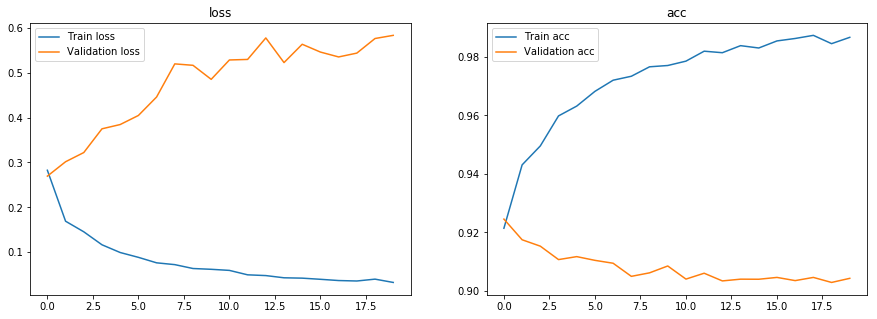

In [50]:
show_final_history(CNN_history)


Something appears to have gone wrong in my implimentation. These graphs are supposed ot be slightly congruents otward each other. the blue line is what we expet: the accuracy and los steadily decrease with each iteration. It seems my augmentaion of the testing and validation data was too much of an augmentaion to successfully apply these models to the data and establish some type of out-of-sample accuracy.